In [50]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.gridspec as gridspec
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D, BatchNormalization
import tensorflow.keras.backend as K

In [51]:
plate_cascade = cv2.CascadeClassifier('Dataset/indian_license_plate.xml')

In [52]:
def detect_plate(img, text=''):
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.2, minNeighbors = 7)
    for (x,y,w,h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :] 
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x+2,y), (x+w-3, y+h-5), (51,181,155), 3) 
    if text!='':
        plate_img = cv2.putText(plate_img, text, (x-w//2,y-h//2), 
                                cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.5, (51,181,155), 1, cv2.LINE_AA)
        
    return plate_img, plate

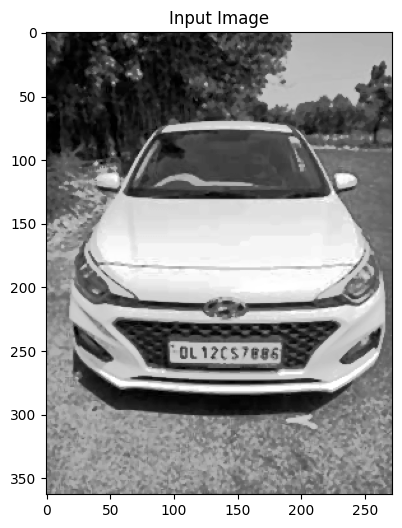

In [85]:
def display(img_, title):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img = cv2.medianBlur(img, 3)
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.equalizeHist(gray_img)

    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    plt.show()

img = cv2.imread('Dataset/cars/DL/DL21.jpg')
display(img, 'Input Image')

In [86]:
output_img, plate = detect_plate(img)

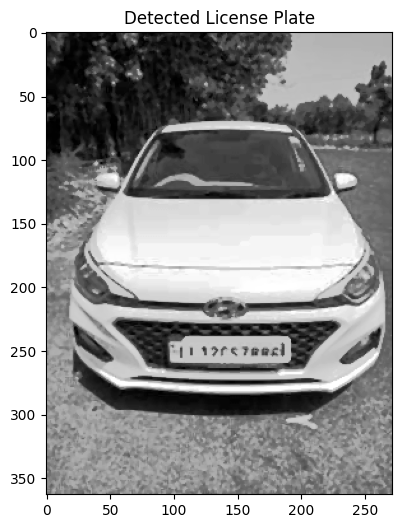

In [87]:
display(output_img, 'Detected License Plate')

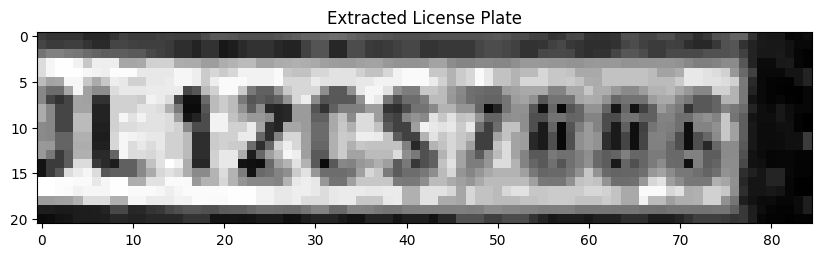

In [88]:
display(plate, 'Extracted License Plate')

In [89]:
def find_contours(dimensions, img) :

    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) 

            char_copy = np.zeros((44,24))
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            char = cv2.subtract(255, char)

            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) 
            
            
    plt.show()
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])
    img_res = np.array(img_res_copy)

    return img_res

In [90]:
def segment_characters(image) :

    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

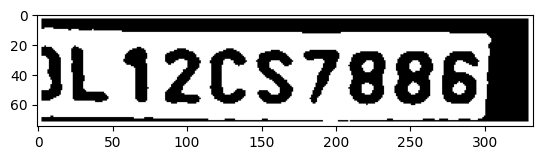

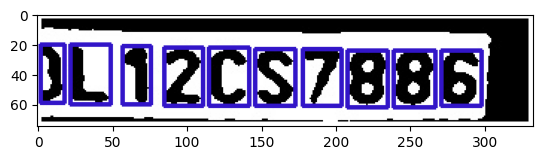

In [91]:
char = segment_characters(plate)

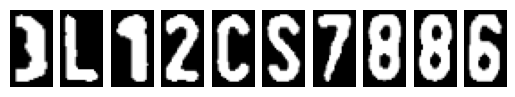

In [92]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

In [93]:
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = 'Dataset/data/data'
train_generator = train_datagen.flow_from_directory(
        path+'/train', 
        target_size=(28,28),  
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val', 
        target_size=(28,28),  
        class_mode='sparse')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [94]:
def f1score(y, y_pred):
  return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
  return tf.py_function(f1score, (y, y_pred), tf.double)

In [95]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))  

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=0.0001), metrics=['Accuracy',custom_f1score])

In [96]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        65600     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                        

In [97]:
class stop_training_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_custom_f1score') > 0.99):
      self.model.stop_training = True

In [98]:
batch_size = 1
callbacks = [stop_training_callback()]
history = model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 80, verbose=1, callbacks=callbacks)

C:\Users\Stephen Jo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/80
864/864 [==============================] - 37s 41ms/step - loss: 3.5985 - Accuracy: 0.0208 - custom_f1score: 0.0208 - val_loss: 3.5838 - val_Accuracy: 0.0278 - val_custom_f1score: 0.0283
Epoch 2/80
864/864 [==============================] - 40s 46ms/step - loss: 3.5865 - Accuracy: 0.0139 - custom_f1score: 0.0139 - val_loss: 3.5837 - val_Accuracy: 0.0278 - val_custom_f1score: 0.0283
Epoch 3/80
368/864 [===========>..................] - ETA: 21s - loss: 3.5849 - Accuracy: 0.0163 - custom_f1score: 0.0163

KeyboardInterrupt: 

In [67]:
model.save('LicensePlateModel.h5')

In [68]:
# model = load_model('LicensePlateModel.h5')

NameError: name 'history' is not defined

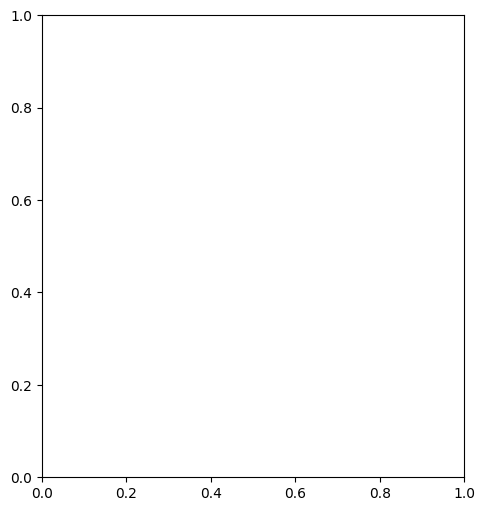

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['Accuracy'], label='Train Accuracy')
plt.plot(history.history['val_Accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [465]:
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): 
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3)        
        y_ = model.predict(img)[0]
        y_ = np.argmax(y_) 
        character = dic[y_]              
        output.append(character)         
    plate_number = ''.join(output) 
    
    return plate_number
print(show_results())

1/1 [==============================] - 0s 45ms/step
3L1ZUS788E


1/1 [==============================] - 0s 35ms/step


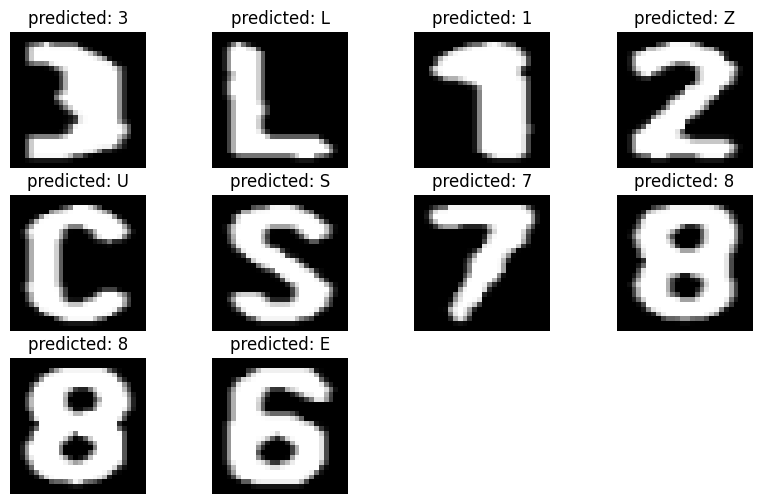

In [466]:
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA) 
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')  
    plt.title(f'predicted: {show_results()[i]}')  
    plt.axis('off')
plt.show() 